In [215]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import morphology
import math
import copy
# from plantcv import plantcv as pcv

# from dsepruning import skel_pruning_DSE

from skimage.io import imread
from skimage.morphology import medial_axis, skeletonize
from scipy.ndimage import distance_transform_edt



(1280, 960, 3)


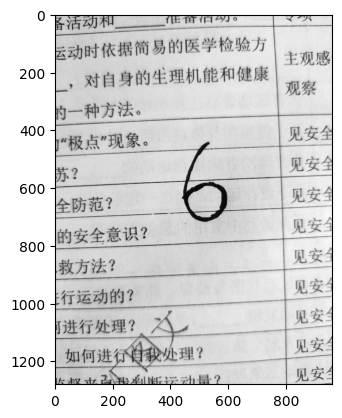

In [216]:
I = cv2.imread('7.jpg')
print(I.shape)
I = I[:,:,1]
plt.imshow(I, cmap='gray')

## 预处理 找到数字位置


1. 滤波去条纹
2. 腐蚀去条纹
3. 膨胀回来

0. 二值化
1. 方框扩大
2. 区域生长

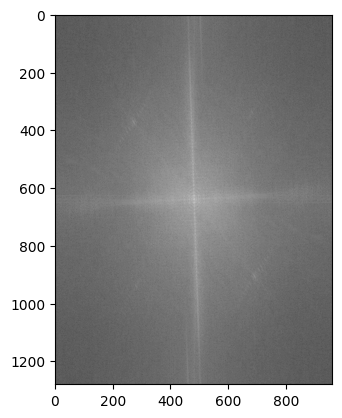

In [217]:
fI = np.fft.fftshift(np.fft.fft2(I))
plt.imshow(np.log(np.abs(fI)), cmap='gray')

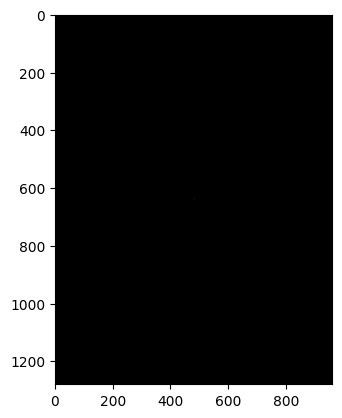

In [218]:
def mask(data):    
    x, y = data.shape
    newData = np.zeros([x, y], dtype=complex)
    for i in range(x):
        for j in range(y):
            if(i<x/2+20 and i>x/2-20 or j>y/2-20 and j<y/2+20):
                newData[i, j] = 0
            else:
                newData[i, j] = data[i, j]    
            if(i<x/2+15 and i>x/2-15 and j>y/2-15 and j<y/2+15):
                newData[i, j] = data[i, j]
            # if(i>x/2+200 or i<x/2-200 or j<y/2-200 or j>y/2+200):
            #     newData[i, j] = data[i, j]


    return newData

maskfI = mask(fI)
plt.imshow(np.abs(maskfI), cmap='gray')

True

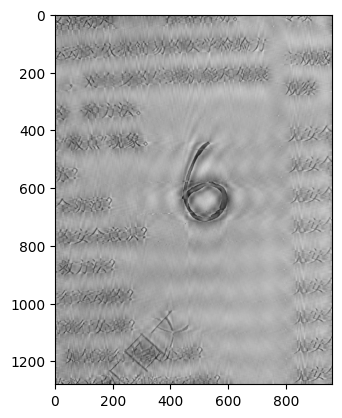

In [219]:
newI = np.fft.ifft2(np.fft.fftshift(maskfI))
plt.imshow(np.real(newI), cmap='gray')
cv2.imwrite('8.jpg',np.real(newI))



True

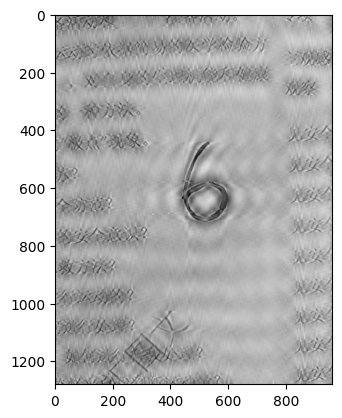

In [220]:
kernel_size = (3,3)

# 应用平滑盒式滤波
smoothed_image = cv2.blur(np.real(newI), kernel_size)
newI = smoothed_image
plt.imshow(newI, cmap='gray')
cv2.imwrite('smmoth_filter.jpg',np.real(newI))


True

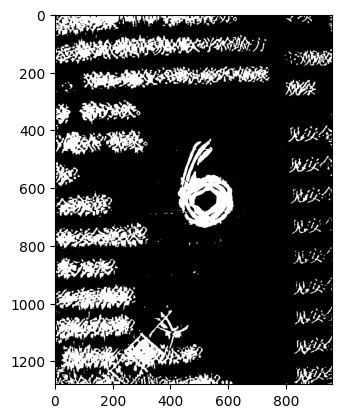

In [221]:
def threshold(data):
    data = np.real(data)
    max = np.max(data)
    thresh = max*3/5
    x, y = data.shape
    newData = np.zeros([x, y])
    for i in range(x):
        for j in range(y):
            if(data[i ,j] < thresh):
                newData[i ,j] = 1
    return newData

thresholdData = threshold(newI)
plt.imshow(thresholdData, cmap='gray')
cv2.imwrite('erzhihua.jpg',thresholdData)
     

## 腐蚀生长

In [222]:
# # Creating kernel
# kernel = np.ones((8, 8), np.uint8)
  
# # Using cv2.erode() method 
# erodeData = cv2.erode(thresholdData, kernel) 

# plt.imshow(erodeData, cmap='gray')

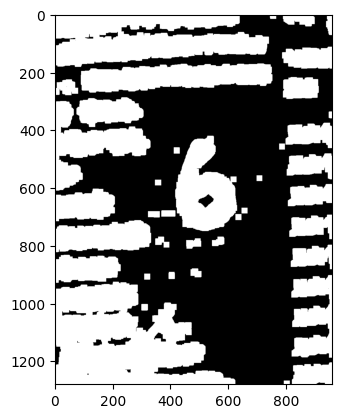

In [223]:
# Creating kernel
kernel = np.ones((20, 20), np.uint8)
  
# Using cv2.erode() method 
dilateData = cv2.dilate(thresholdData, kernel) 

plt.imshow(dilateData, cmap='gray')

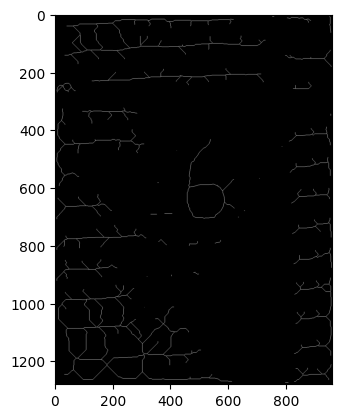

In [224]:
skeleton0 = morphology.skeletonize(dilateData, method='lee')
skeleton = skeleton0.astype(np.uint8)*255
plt.imshow(skeleton, cmap='gray')

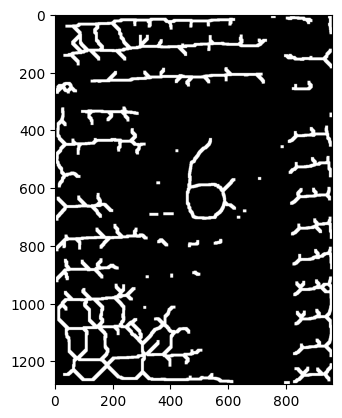

In [225]:
# Creating kernel
kernel = np.ones((10, 10), np.uint8)
  
# Using cv2.erode() method 
dilateData = cv2.dilate(skeleton, kernel) 

plt.imshow(dilateData, cmap='gray')

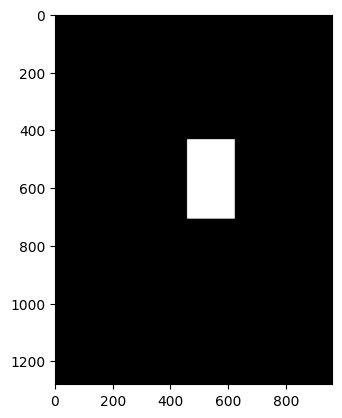

In [226]:
def get_bounding_box(skeleton):
    # 查找骨架的轮廓
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 创建空白图像
    bounding_box = np.zeros_like(skeleton)
    i, j = bounding_box.shape
    for contour in contours:
        # 计算骨架的边界框
        x, y, w, h = cv2.boundingRect(contour)
        # print(x+h/2,y+w/2)
        if(abs(x+h/2-i/2)<200 and abs(y+w/2-j/2)<200 and w > 50 and h > 60):
        # 绘制边界框
            cv2.rectangle(bounding_box, (x, y), (x + w, y + h), 255, -1)

            return bounding_box, x, y, w, h

bound, x, y, w, h = get_bounding_box(skeleton)
plt.imshow(bound,cmap='gray')


456 433 164 274


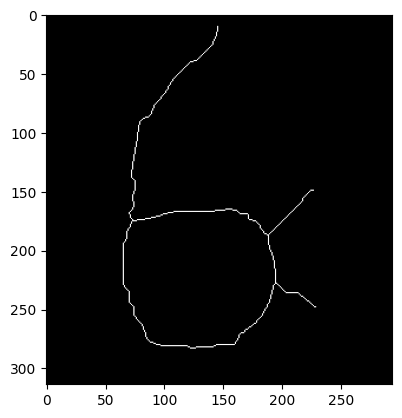

In [227]:
def frame(skeleton, bound, x, y, w, h):   
    print(x,y,w,h)
    temp = x
    x = y
    y = temp
    x = int(x + h/2 - max(h,w)/2-10)
    y = int(y + w/2 - max(h,w)/2-10)
    w = max(h, w)+20
    h = max(h, w)+20

    maskSk = np.zeros([h, w])
    for i in range(h):
        for j in range(w):
            if x + i < 1280 and y + j < 960 :
                maskSk[i, j] = skeleton[x + i, y + j] * bound[x + i, y + j]
    return maskSk

maskSk = frame(skeleton, bound, x, y, w, h)
plt.imshow(maskSk,cmap='gray')

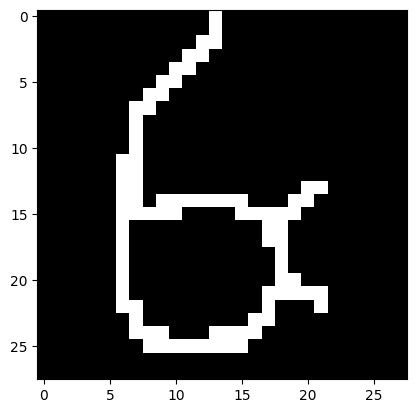

In [228]:
resizedData = cv2.resize(maskSk,(28,28), interpolation=cv2.INTER_AREA)
_,resizedData = cv2.threshold(resizedData, 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(resizedData, cmap='gray')

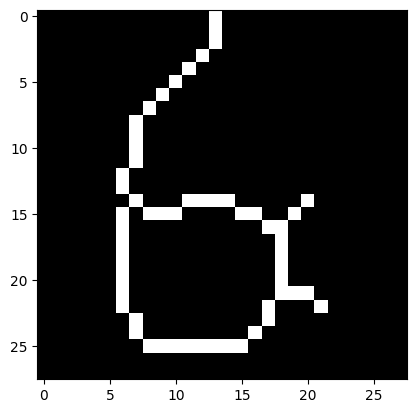

In [229]:
skeleton0 = morphology.skeletonize(resizedData, method='lee')
reskeleton = skeleton0.astype(np.uint8)*255
plt.imshow(reskeleton, cmap='gray')

start point: [0, 13]
boundary [[0, 13], [1, 13], [2, 13], [3, 12], [4, 11], [5, 10], [6, 9], [7, 8], [8, 7], [9, 7], [10, 7], [11, 7], [12, 6], [13, 6], [14, 7], [15, 8], [15, 9], [15, 10], [14, 11], [14, 12], [14, 13], [14, 14], [15, 15], [15, 16], [16, 17], [16, 18], [15, 19], [14, 20], [15, 19], [16, 18], [17, 18], [18, 18], [19, 18], [20, 18], [21, 19], [21, 20], [22, 21], [21, 20], [21, 19], [21, 18], [22, 17], [23, 17], [24, 16], [25, 15], [25, 14], [25, 13], [25, 12], [25, 11], [25, 10], [25, 9], [25, 8], [24, 7], [23, 7], [22, 6], [21, 6], [20, 6], [19, 6], [18, 6], [17, 6], [16, 6], [15, 6], [14, 7], [13, 6], [12, 6], [11, 7], [10, 7], [9, 7], [8, 7], [7, 8], [6, 9], [5, 10], [4, 11], [3, 12], [2, 13], [1, 13], [0, 13]]
chaincode [6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 6, 7, 7, 0, 0, 1, 0, 0, 0, 7, 0, 7, 0, 1, 1, 5, 5, 6, 6, 6, 6, 7, 0, 7, 3, 4, 4, 5, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2]


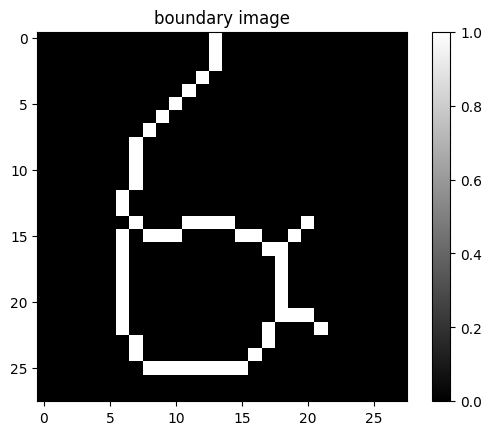

In [230]:
# binary image
def binary(data):
    max = np.max(data)
    x, y = data.shape
    newData = np.zeros([x, y])
    for i in range(x):
        for j in range(y):
            if (data[i, j] > max/2):
                newData[i ,j] = 1
    return newData

# boundary tracing
def boundaryTracing(data):
    x, y = data.shape
    # make binary image
    binaryData = binary(data)
    start = [0, 0]

    # find start point
    flag = False
    for i in range(x):
        for j in range(y):
            # print('2')
            if (binaryData[i, j] == 1):
                start[0] = i
                start[1] = j
                flag = True
                # print('ok',start)
                break
        if(flag):
            break    
            
    b = [0, 0]
    b[0] = start[0]
    b[1] = start[1]
    
    c = [0, 0]
    c[0] = b[0]
    c[1] = b[1]
    if(b[1] == 0):
        c[0] = b[0] - 1
    else :   
        c[1] = b[1] - 1
    
    boundaryList = []
    boundaryList.append(start)
    print('start point:',start)
    # find chain
    cList = [[0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1], [1, 0], [1, 1]]
    number = 4
    c = cList[number]
    # print(start,b,c)

    chainCode = []

    # search for next point
    while b == start:
        if(binaryData[b[0]+c[0], b[1]+c[1]] == 1):# find
            b = [b[0]+c[0], b[1]+c[1]]
            boundaryList.append(b)
            chainCode.append(number)
            # print(number)
            # print(cList[number + 1][0] - cList[number][0])
            nextnum = number + 1
            if(number==7):
                nextnum = 0
            number = cList.index([cList[nextnum][0] - cList[number][0], cList[nextnum][1] - cList[number][1]])
            number -= 1
            if(number == -1):
                number = 7
        else:# next
            number -= 1
            if(number == -1):
                number = 7
        c = cList[number]

    # search until back to start
    while b != start:
        if(binaryData[b[0]+c[0], b[1]+c[1]] == 1):# find
            b = [b[0]+c[0], b[1]+c[1]]
            boundaryList.append(b)
            chainCode.append(number)
            numberbig = number+1
            if(numberbig == 8):
                numberbig = 0
            number = cList.index([cList[numberbig][0] - cList[number][0], cList[numberbig][1] - cList[number][1]])
            number -= 1
            if(number == -1):
                number = 7
        else:# next
            number -= 1
            if(number == -1):
                number = 7
        c = cList[number]

    print('boundary',boundaryList)
    print('chaincode',chainCode)
    boundaryImg = np.zeros([x, y])
    
    for boundary in boundaryList:
        boundaryImg[boundary[0], boundary[1]] = 1
    return boundaryImg, boundaryList, chainCode

boundaryImg, boundaryList, chainCode = boundaryTracing(reskeleton)
plt.imshow(boundaryImg, cmap='gray') 
plt.colorbar()
plt.title('boundary image')
plt.show()

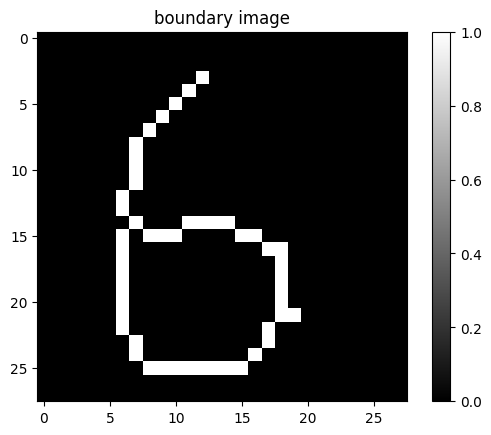

In [231]:
# 剪枝
def cutoff(chain, boundaryList, step):
    leng = len(chain)
    for k in range(step):
        for i in range(leng):
            if(abs(chain[i]-chain[i-1])==4):
                chain[i] = 20
                chain[i-1] = 20
                boundaryList[i] = [0,0]
                boundaryList[i-1] = [0,0]
        while 20 in chain:
            chain.remove(20)
        leng = len(chain)
        while [0,0] in boundaryList:
            boundaryList.remove([0,0])
    newData = np.zeros([28, 28])
    for boundary in boundaryList:
        newData[boundary[0], boundary[1]] = 1

    plt.imshow(newData, cmap='gray') 
    plt.colorbar()
    plt.title('boundary image')
    plt.show()
    return newData
        
newI = cutoff(chainCode, boundaryList, 3)    

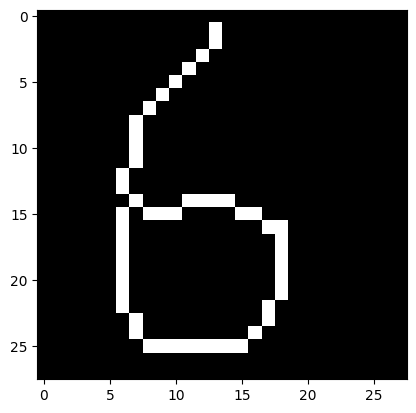

In [232]:


def hitornot(img,SE): # 目标是1，背景是0
    img = copy.copy(img)
    r,c = img.shape[0],img.shape[1]
    img = np.pad(img,((1,1),(1,1)),'constant',constant_values=0)
    img = img.astype(np.float64) 
    res = np.zeros_like(img,dtype=np.uint8)
    for p in range(1,r+1):
        for q in range(1,c+1):
            area = copy.copy(img[p-1:p+2,q-1:q+2])
            if len(SE) == 2:
                area[SE[1][:,0],SE[1][:,1]] = math.inf
            if (area == SE[0]).all():
                res[p,q] = 1
    return res[1:-1,1:-1]

def refinement(img,B):
    img = copy.copy(img)
    hit = hitornot(img,B)
    loc1 = np.argwhere(img==1).tolist()
    loc2 = np.argwhere(hit==1).tolist()
    loc = np.array([k for k in loc1 if k in loc2])
    if len(loc)!=0:
        img[loc[:,0],loc[:,1]] = 0
    return img


# 裁剪
def crop(img): # 需要目标是1，背景是0
    SE1 = [np.array([[math.inf,0,0],[1,1,0],[math.inf,0,0]]),np.array([[0,0],[2,0]])]
    SE2 = [np.array([[math.inf,1,math.inf],[0,1,0],[0,0,0]]),np.array([[0,0],[0,2]])]
    SE3 = [np.array([[0,0,math.inf],[0,1,1],[0,0,math.inf]]),np.array([[0,2],[2,2]])]
    SE4 = [np.array([[0,0,0],[0,1,0],[math.inf,1,math.inf]]),np.array([[2,0],[2,2]])]
    SE5 = [np.array([[1,0,0],[0,1,0],[0,0,0]])]
    SE6 = [np.array([[0,0,1],[0,1,0],[0,0,0]])]
    SE7 = [np.array([[0,0,0],[0,1,0],[0,0,1]])]
    SE8 = [np.array([[0,0,0],[0,1,0],[1,0,0]])]
    ''' Step1: 删除3个即以下长度的分枝, 得到X1 '''
    X1 = copy.copy(img)
    for _ in range(3): # 连续3次操作
        for i in range(8): # 结构元序列长度为8
            SE = eval(f'SE{i+1}')
            X1 = refinement(X1,SE)
    ''' Step2: 得到X1中端点集合X2 '''
    g = []
    for i in range(8):
        SE = eval(f'SE{i+1}')
        kk = hitornot(X1,SE)
        res = np.argwhere(kk==1)
        g.extend(res)
    X2 = np.zeros_like(img,dtype=np.uint8)
    if len(g)!=0:
        g = np.array(g)
        X2[g[:,0],g[:,1]] = 1
    ''' Step3: 对端点连续进行3次膨胀 '''
    H = np.ones((3,3),dtype=np.uint8)
    X3 = copy.copy(X2)
    loc2 = np.argwhere(img==1).tolist() # 原图A
    for _ in range(3):
        X3 = cv2.dilate(X3,H,iterations=1)
        loc1 = np.argwhere(X3==1).tolist()
        loc = np.array([k for k in loc1 if not k in loc2]) # 与原图A做交集
        if len(loc)!=0:
            X3[loc[:,0],loc[:,1]] = 0
    ''' Step4: 取并集 '''
    X4 = np.zeros_like(img,dtype=np.uint8)
    loc1 = np.argwhere(X1==1).tolist()
    loc2 = np.argwhere(X3==1).tolist()
    loc1.extend(loc2)
    loc1 = np.array(loc1)
    X4[loc1[:,0],loc1[:,1]] = 1
    return X4
 
 
    # 测试crop函数
    # 《数字图像处理》第三版 P421 图9.25(a)
img = np.zeros((12,16),dtype=np.uint8)
black =[[2,7],[2,8],[2,9],[3,6],[3,10],[4,2],[4,5],[5,2],[5,4],[5,11],[6,2],[6,3],[6,11],[6,12],\
            [7,3],[7,10],[7,12],[8,4],[8,10],[8,12],[9,3],[9,10],[9,12],[10,3],[10,9],[10,12],[10,15],\
            [11,4],[11,5],[11,6],[11,7],[11,8],[11,13],[11,14]]
black = np.array([[i[0]-1,i[1]-1] for i in black])
img[black[:,0],black[:,1]] = 1
# print(img)
pruneData = crop(reskeleton)
plt.imshow(pruneData, cmap='gray')


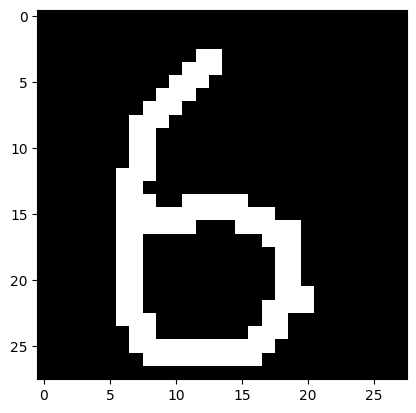

In [235]:
# Creating kernel
kernel = np.ones((2, 2), np.uint8)
  
# Using cv2.erode() method 
finalData = cv2.dilate(newI, kernel) 

plt.imshow(finalData, cmap='gray')

True

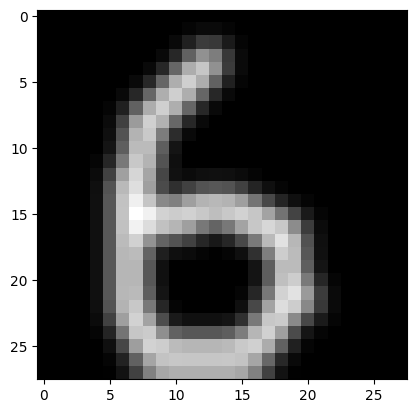

In [237]:
#平滑
kernel_size = (3, 3)
finalData = cv2.GaussianBlur(finalData*8, kernel_size,  sigmaX=0.8)
plt.imshow(finalData,cmap='gray')
# save
cv2.imwrite('test.png',finalData/np.max(finalData)*255)

## 预处理流程

1. 读入数据

2. 频域滤波 为了消除周期噪声，也就是纸张条纹

- 还不能精确去除周期噪声

3. 二值化

4. 膨胀，为了让数字连成一体

5. 骨骼化

6. 框选骨骼， 找出最接近中心的框作为mask

7. 用mask取出roi，注意mask要比数字大一点留边缘， resize到28*28

8. 再次骨骼化

9. 剪枝，模板匹配或者链码

10. 膨胀

11. 保存图片

## 处理细节

- 框选的数字留出边缘空白，便于数字识别

- 数字稍微膨胀2x2，便于识别

- 预处理参数和原始大小有关